# Imports

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn: model selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scikit-learn: regressors and decomposition
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Statsmodels and Scipy
import statsmodels.api as sm
import scipy.stats as stats

# XGBoost
from xgboost import XGBRegressor

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data Prep

In [3]:
df = pd.read_csv("../data/regression.csv")

In [4]:
df = df.dropna()

In [5]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Linear Regression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse_num = mean_squared_error(y_test, y_pred)

In [10]:
results_reg = pd.DataFrame([
    {
        'Modelo': 'Linear Regression',
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'N_features': len(X.columns)
    }
])
results_reg

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.70014,12


Modelo         MSE      RMSE       MAE       R2
 Ridge 6139.201206 78.353055 61.638011 0.700107
 Lasso 6135.228052 78.327697 61.628791 0.700301


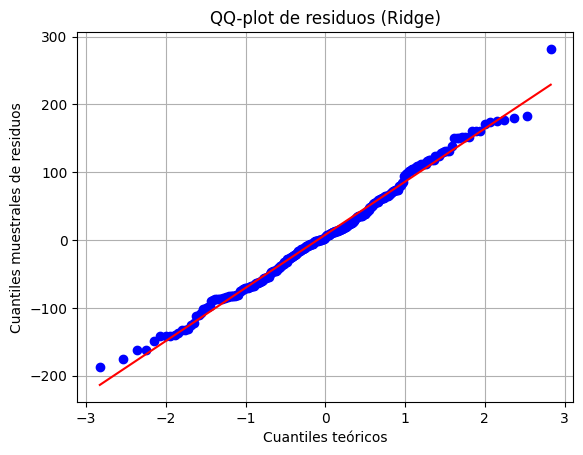

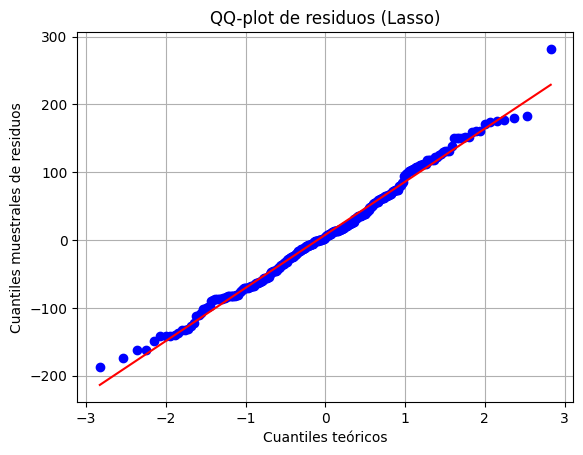

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

results = pd.DataFrame({
    'Modelo': ['Ridge', 'Lasso'],
    'MSE': [
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_lasso)
    ],
    'R2': [
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso)
    ]
})
print(results.to_string(index=False))

residuals = y_test - y_pred_ridge
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot de residuos (Ridge)")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles muestrales de residuos")
plt.grid(True)
plt.show()

res_lasso = y_test - y_pred_lasso
plt.figure()
stats.probplot(res_lasso, dist="norm", plot=plt)
plt.title("QQ-plot de residuos (Lasso)")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles muestrales de residuos")
plt.grid(True)
plt.show()

# KNN

In [12]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

In [13]:
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

In [14]:
new_row = {
    'Modelo'     : 'k-NN Regressor (k=5) escaladas',
    'MSE'        : mse,
    'RMSE'       : rmse,
    'MAE'        : mae,
    'R2'         : r2,
    'N_features': len(X.columns)
}

results_reg = pd.concat([results_reg, pd.DataFrame([new_row])], ignore_index=True)
results_reg

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12


# KNN + PCA & GridSearch

In [15]:
param_grid = {
    'n_neighbors': [3, 7,13, 17, 25],
    'weights'    : ['uniform', 'distance']
}

n_feats    = X_train_scaled.shape[1]
components = [n_feats, int(0.75*n_feats), int(0.50*n_feats), int(0.25*n_feats)]

best = {'cv_mse': np.inf}

for n_comp in components:
    pca = PCA(n_components=n_comp).fit(X_train_scaled)
    Xtr = pca.transform(X_train_scaled)
    Xte = pca.transform(X_test_scaled)

    knn_cv = GridSearchCV(
        KNeighborsRegressor(metric='euclidean'),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    knn_cv.fit(Xtr, y_train)

    cv_mse = -knn_cv.best_score_
    y_pred = knn_cv.predict(Xte)
    test_mse  = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae  = mean_absolute_error(y_test, y_pred)
    test_r2   = r2_score(y_test, y_pred)

    if cv_mse < best['cv_mse']:
        best.update({
            'n_comp'    : n_comp,
            'params'    : knn_cv.best_params_,
            'cv_mse'    : cv_mse,
            'test_mse'  : test_mse,
            'test_rmse' : test_rmse,
            'test_mae'  : test_mae,
            'test_r2'   : test_r2
        })

new_row = {
    'Modelo'    : f"k-NN grid (k={best['params']['n_neighbors']}, comp={best['n_comp']})",
    'MSE'       : best['test_mse'],
    'RMSE'      : best['test_rmse'],
    'MAE'       : best['test_mae'],
    'R2'        : best['test_r2'],
    'N_features': best['n_comp']
}

results_reg = pd.concat([results_reg, pd.DataFrame([new_row])], ignore_index=True)
results_reg

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12


# OLS

In [16]:
X_train_ols = sm.add_constant(X_train_scaled)
X_test_ols  = sm.add_constant(X_test_scaled)

ols = sm.OLS(y_train, X_train_ols).fit()
y_pred_ols = ols.predict(X_test_ols)

mse_ols  = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)
mae_ols  = mean_absolute_error(y_test, y_pred_ols)
r2_ols   = r2_score(y_test, y_pred_ols)

new_row = {
    'Modelo'     : 'OLS Regression escaladas',
    'MSE'         : mse_ols,
    'RMSE'        : rmse_ols,
    'MAE'         : mae_ols,
    'R2'          : r2_ols,
    'N_features'  : len(X.columns)
}

results_reg = pd.concat([results_reg, pd.DataFrame([new_row])], ignore_index=True)
display(results_reg)

print(ols.summary())

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     256.1
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          2.28e-316
Time:                        20:36:21   Log-Likelihood:                -6762.1
No. Observations:                1178   AIC:                         1.355e+04
Df Residuals:                    1165   BIC:                         1.362e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3697      2.206     -1.074      0.2

# Decision Tree

In [17]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

mse_dt  = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt  = mean_absolute_error(y_test, y_pred_dt)
r2_dt   = r2_score(y_test, y_pred_dt)

new_row = {
    'Modelo'    : 'Decision Tree escaladas',
    'MSE'        : mse_dt,
    'RMSE'       : rmse_dt,
    'MAE'        : mae_dt,
    'R2'         : r2_dt,
    'N_features' : len(X.columns)
}

results_reg = pd.concat([results_reg, pd.DataFrame([new_row])],
                        ignore_index=True)
display(results_reg)

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12


# Random Forest

In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

new_row = {
    'Modelo'    : 'Random Forest escaladas',
    'MSE'        : mse_rf,
    'RMSE'       : rmse_rf,
    'MAE'        : mae_rf,
    'R2'         : r2_rf,
    'N_features' : len(X.columns)
}

results_reg = pd.concat([results_reg, pd.DataFrame([new_row])],
                        ignore_index=True)
display(results_reg)

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12


# Ada Boost

In [19]:
param_grid_ada = {
    'n_estimators'    : [50, 100, 150],
    'learning_rate'   : [0.01, 0.1, 1.0],
    'loss'            : ['linear', 'square', 'exponential']
}

grid_search_ada = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=param_grid_ada,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search_ada.fit(X_train_scaled, y_train)

best_ada    = grid_search_ada.best_estimator_
y_pred_ada  = best_ada.predict(X_test_scaled)

print("Mejores parámetros AdaBoost:", grid_search_ada.best_params_)

mse_ada  = mean_squared_error(y_test, y_pred_ada)
rmse_ada = np.sqrt(mse_ada)
mae_ada  = mean_absolute_error(y_test, y_pred_ada)
r2_ada   = r2_score(y_test, y_pred_ada)

new_row = {
    'Modelo'     : 'AdaBoostRegressor (grid) escaladas',
    'MSE'        : mse_ada,
    'RMSE'       : rmse_ada,
    'MAE'        : mae_ada,
    'R2'         : r2_ada,
    'N_features' : len(X.columns)
}
results_reg = pd.concat([results_reg, pd.DataFrame([new_row])], ignore_index=True)
display(results_reg)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros AdaBoost: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 150}


,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12


# XGBoost

In [20]:
param_grid_xgb = {
    'n_estimators'  : [50, 100, 150],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth'     : [3, 5, 7],
    'subsample'     : [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(
        objective='reg:squarederror', random_state=42,
    ),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb    = grid_search_xgb.best_estimator_
y_pred_xgb  = best_xgb.predict(X_test_scaled)

print("Mejores parámetros XGBoost:", grid_search_xgb.best_params_)

mse_xgb  = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb   = r2_score(y_test, y_pred_xgb)

new_row = {
    'Modelo'     : 'XGBRegressor (grid) escaladas',
    'MSE'        : mse_xgb,
    'RMSE'       : rmse_xgb,
    'MAE'        : mae_xgb,
    'R2'         : r2_xgb,
    'N_features' : len(X.columns)
}
results_reg = pd.concat([results_reg, pd.DataFrame([new_row])], ignore_index=True)
display(results_reg)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12


# Redes Neuronales

/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor MSE: 17228.6159
MLPRegressor R²:  0.1584


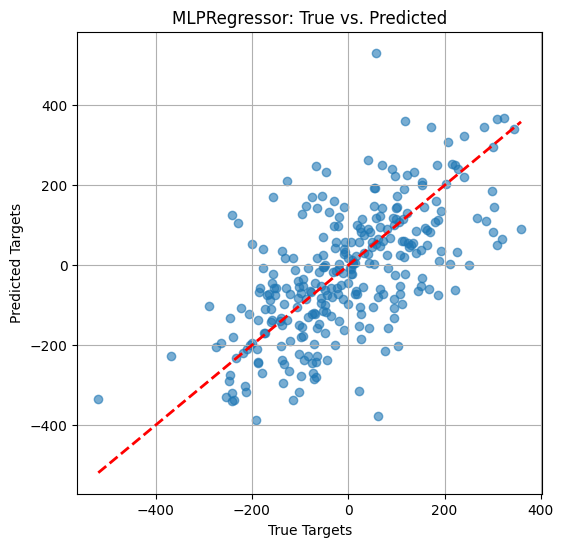

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12
8,MLPRegressor,17228.615924,131.257822,100.251268,0.158401,12


In [21]:
reg = MLPRegressor(
    hidden_layer_sizes=(60,),
    solver='lbfgs',
    alpha=1.0,
    random_state=1,
    max_iter=1000
)
reg.fit(X_train_scaled, y_train)
n_features = X_train_scaled.shape[1]

y_pred_reg = reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_reg)
r2  = r2_score(y_test, y_pred_reg)
print(f"MLPRegressor MSE: {mse:.4f}")
print(f"MLPRegressor R²:  {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_reg, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("True Targets")
plt.ylabel("Predicted Targets")
plt.title("MLPRegressor: True vs. Predicted")
plt.grid(True)
plt.show()

results_reg.loc[len(results_reg)] = {
    'Modelo':    'MLPRegressor',
    'MSE':       mean_squared_error(y_test,   y_pred_reg),
    'RMSE':      np.sqrt(mean_squared_error(y_test,   y_pred_reg)),
    'MAE':       mean_absolute_error(y_test,  y_pred_reg),
    'R2':        r2_score(y_test,            y_pred_reg),
    'N_features': n_features
}

display(results_reg)

/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19429.8848 - mean_absolute_error: 111.0767 - val_loss: 20289.2207 - val_mean_absolute_error: 112.5766
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19286.1309 - mean_absolute_error: 108.2360 - val_loss: 19806.6426 - val_mean_absolute_error: 111.2844
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20579.1172 - mean_absolute_error: 113.0644 - val_loss: 18874.8184 - val_mean_absolute_error: 108.6872
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19047.1914 - mean_absolute_error: 108.3297 - val_loss: 17357.2871 - val_mean_absolute_error: 104.2612
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17270.4004 - mean_absolute_error: 104.6618 - val_loss: 15237.5488 - val_mean_absolute_error: 97.4573
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14672.7129 - mean_absolute_error: 95.8562 - val_loss: 12923.5508 - val_mean_absolute_error: 89.2519
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━

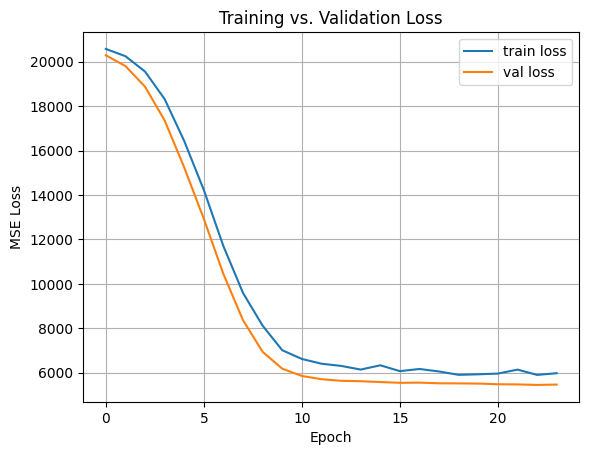

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


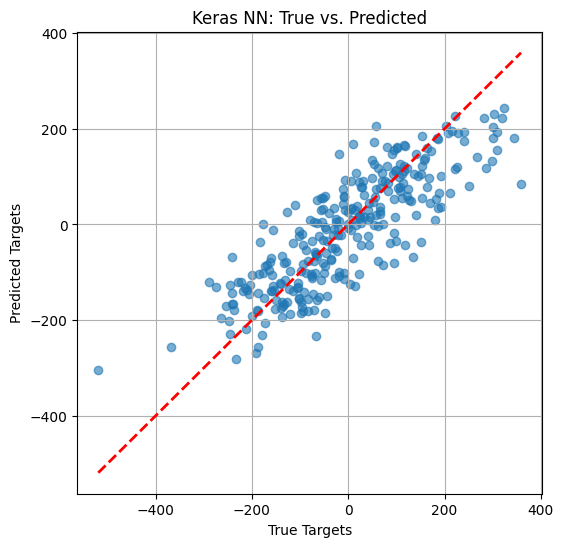

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12
8,MLPRegressor,17228.615924,131.257822,100.251268,0.158401,12
9,KerasNN,6364.388966,79.777121,62.861893,0.689107,12


In [22]:
def build_regression_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

model_reg = build_regression_model(X_train_scaled.shape[1])

early_stop = EarlyStopping(
    monitor='mean_absolute_error',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model_reg.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

mse_nn, mae_nn = model_reg.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Net Regression MSE: {mse_nn:.4f}")
print(f"Neural Net Regression MAE: {mae_nn:.4f}")
print(f"Neural Net Regression R²: {r2_score(y_test, model_reg.predict(X_test_scaled)):.4f}")

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred_nn = model_reg.predict(X_test_scaled).flatten()
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_nn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("True Targets")
plt.ylabel("Predicted Targets")
plt.title("Keras NN: True vs. Predicted")
plt.grid(True)
plt.show()

results_reg.loc[len(results_reg)] = {
    'Modelo':    'KerasNN',
    'MSE':       mean_squared_error(y_test,   y_pred_nn),
    'RMSE':      np.sqrt(mean_squared_error(y_test,   y_pred_nn)),
    'MAE':       mean_absolute_error(y_test,  y_pred_nn),
    'R2':        r2_score(y_test,            y_pred_nn),
    'N_features': n_features
}

display(results_reg)

In [23]:
results_reg = results_reg.sort_values(by='MSE', ascending=True)
display(results_reg)

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
9,KerasNN,6364.388966,79.777121,62.861893,0.689107,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
8,MLPRegressor,17228.615924,131.257822,100.251268,0.158401,12


In [24]:
results_reg = results_reg.sort_values(by='R2', ascending=False)
display(results_reg)

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
9,KerasNN,6364.388966,79.777121,62.861893,0.689107,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
8,MLPRegressor,17228.615924,131.257822,100.251268,0.158401,12


In [25]:
results_reg = results_reg.sort_values(by=['MSE', 'R2'], ascending=[True, False])
display(results_reg)

,Modelo,MSE,RMSE,MAE,R2,N_features
0,Linear Regression,6138.514703,78.348674,61.638441,0.700140,12
3,OLS Regression escaladas,6138.514703,78.348674,61.638441,0.700140,12
9,KerasNN,6364.388966,79.777121,62.861893,0.689107,12
7,XGBRegressor (grid) escaladas,6939.093852,83.301224,64.691668,0.661033,12
5,Random Forest escaladas,7293.616879,85.402675,67.020350,0.643715,12
6,AdaBoostRegressor (grid) escaladas,7793.258046,88.279432,69.394143,0.619308,12
2,"k-NN grid (k=17, comp=12)",9812.593252,99.058534,77.475050,0.520666,12
1,k-NN Regressor (k=5) escaladas,10640.480296,103.152704,80.952047,0.480224,12
4,Decision Tree escaladas,16578.446162,128.757315,103.574863,0.190161,12
8,MLPRegressor,17228.615924,131.257822,100.251268,0.158401,12


# Comentarios

* Se entrenaron y compararon 9 modelos de regresión: Regresión Lineal, OLS, K‑NN, Árbol de Decisión, Random Forest, AdaBoost, XGBoost, un MLP de *scikit‑learn* y una red neuronal densa en Keras, todos con la misma partición 80 / 20 y variables escaladas cuando era necesario.

* Las métricas de referencia muestran que la Regresión Lineal simple lidera con MSE ≈ 6 139, RMSE ≈ 78 y R² ≈ 0.70; el modelo OLS alcanza las mismas métricas.

* Se aplicó regularización con Ridge (α=1.0) y Lasso (α=0.1):
  * Ridge obtuvo MSE ≈ 6 139, RMSE ≈ 78.35, MAE ≈ 61.64 y R² ≈ 0.7001.
  * Lasso obtuvo MSE ≈ 6 135, RMSE ≈ 78.33, MAE ≈ 61.63 y R² ≈ 0.7003.

  Los QQ-plots de residuos de ambos modelos (Ridge y Lasso) muestran una excelente aproximación a la normalidad, pero la regularización no mejoró el R² ni redujo de forma significativa el error respecto al modelo lineal sin penalización.

* Aún con ensambles no mejoró el desempeño:
  * Random Forest (100 árboles) alcanza R² 0.64.
  * AdaBoost óptimo con 150 stumps y learning\_rate 1.0 se queda en R² 0.62.
  * XGBoost con 100 árboles (profundidad 3, eta 0.1) llega a R² 0.66.
      
  El grid search confirma que aumentar la complejidad no aporta una ganancia real.

* K‑NN, aún tras probar distintos valores de k y aplicar reducción de dimensión con PCA, no se logró un buen desempeño: obtiene RMSE ≈ 99 y R² ≈ 0.52. Esto se debe a que, aunque las variables están escaladas, ninguna de ellas tiene relación significativa con la varlable objetivo.

* El Árbol de Decisión y el MLP muestran error de entrenamiento casi nulo pero caen a R² ≤ 0.19 y 0.18 en prueba, lo que podría indicar un sobreajuste.

* Sugerimos elegir entre Regresión Lineal/OLS por su transparencia, costo computacional mínimo y desempeño destacado.
